In [1]:
# Set parent path for imports.

import os
import sys

# Get desired path:
path = os.path.dirname(os.getcwd())

# Add the parent directory to sys.path
sys.path.append(path)

In [2]:
import numpy as np

from statespace.models import NVMLangevinModel
from statespace.models import NVMConstantVelocityModel

from stochastic.processes import GammaProcess
from stochastic.processes import TemperedStableProcess
from stochastic.processes import GeneralisedInverseGaussianProcess

from statespace.methods import KalmanFilter, SequentialCollapsedGaussianMCMCFilter

import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('BARC.L.csv').iloc[0:-1:30]

In [4]:
T = np.linspace(start=0., stop=100, num=data['Date'].shape[0]).reshape(-1, 1)
y = data['Adj Close'].values.reshape(1, -1, 1, 1)

In [5]:
data['Adj Close'].pct_change().rolling(4).mean().std()

0.08693336033252197

In [6]:
gamma_process_params = {"beta":1., "C":1.}
# subordinator = GammaProcess(**gamma_process_params)

tempered_stable_process_params = {"alpha":0.6, "beta":0.1, "C":0.5}
# subordinator = TemperedStableProcess(**tempered_stable_process_params)

gig_process_params = {"lam":-0.8, "gamma":0.01, "delta":1.0}
subordinator = GeneralisedInverseGaussianProcess(**gig_process_params)

Residual approximation mode is set to Gaussian approximation.
Simulation method is set to improved version.
Residual approximation method is set to lower bounding method.
Residual approximation mode is set to Gaussian approximation.
Residual approximation mode is set to Gaussian approximation.


In [7]:
mu = 0.2
theta = -0.2
sigma = 0.01
sigma_eps = 0.1

In [8]:
n_particles = 1
langevin_model = NVMLangevinModel(subordinator=subordinator, theta=theta, mu=mu, sigma=sigma, sigma_eps=sigma_eps, shape=(2,1), n_particles=n_particles)

In [9]:
inference_method = SequentialCollapsedGaussianMCMCFilter(model=langevin_model, prior=None, proposal=None)

The prior configuration is not valid.


In [10]:
# Initialise arrays
x_init = np.random.normal(loc=0., scale=0.3, size=(langevin_model.n_particles, 2, 1))

P_init = np.random.normal(loc=0., scale=1., size=(langevin_model.n_particles, 2, 2))
P_init = np.transpose(P_init, axes=[0, 2, 1]) @ P_init

In [11]:
history = inference_method.filter(times=T, y=y[0][np.newaxis], x_init=x_init, P_init=P_init, n_samples=20, burn_in=10)

/Users/yaman/models/stochastic/processes.py:739: RuntimeWarning: invalid value encountered in divide
  envelope_fnc = (((2*self.delta**2)**self.abs_lam)*incgammal(self.abs_lam, (z1**2)*x_series/(2*self.delta**2))*self.abs_lam*(1+self.abs_lam)
/Users/yaman/models/stochastic/processes.py:744: RuntimeWarning: divide by zero encountered in divide
  z_series = np.sqrt(((2*self.delta**2)/x_series)*gammaincinv(self.abs_lam, u_z*gammainc(self.abs_lam, (z1**2)*x_series/(2*self.delta**2))))
/Users/yaman/models/stochastic/processes.py:744: RuntimeWarning: invalid value encountered in multiply
  z_series = np.sqrt(((2*self.delta**2)/x_series)*gammaincinv(self.abs_lam, u_z*gammainc(self.abs_lam, (z1**2)*x_series/(2*self.delta**2))))
/Users/yaman/models/stochastic/processes.py:754: RuntimeWarning: invalid value encountered in divide
  envelope_fnc = (((2*self.delta**2)**self.abs_lam)*incgammal(self.abs_lam, (z1**2)*x_series/(2*self.delta**2))*self.abs_lam*(1+self.abs_lam)
/Users/yaman/models/stochas

In [12]:
inference_method.model.I.subordinator.t_series.shape

(1, 71136)

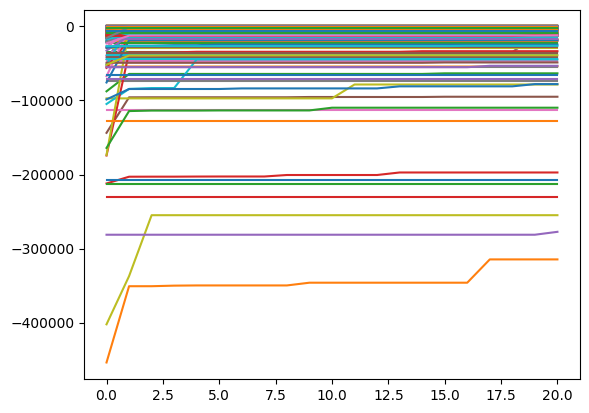

In [13]:
# Log marginal likelihood for each individual iteration

fig, ax = plt.subplots()

ax.plot(np.array(inference_method.log_evidence)[:,:,0,0,0].T)

#ax.plot(np.log(np.array(inference_method_inference.log_evidence)[:,:,0,0].T - np.array(inference_method_inference.log_evidence)[:,:,0,0].T.min()))

plt.show()

In [14]:
post_means = inference_method.x_est[0][1:]
post_vars = np.array([np.diag(COV) for COV in inference_method.P_est[0][1:]])

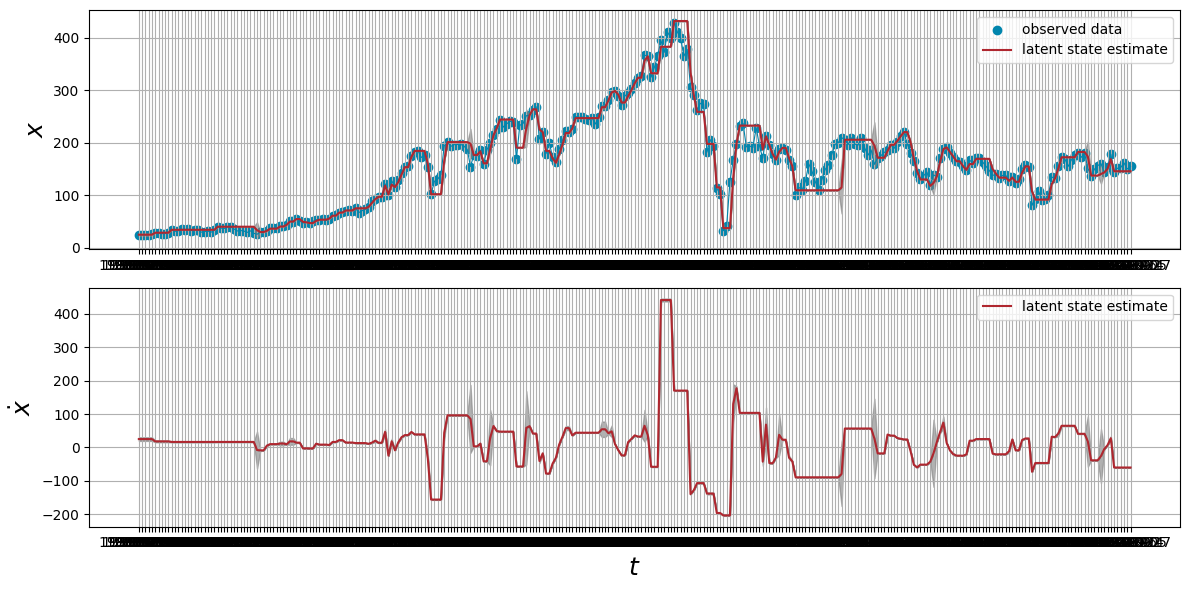

In [15]:
fig, ax = plt.subplots(nrows=2, figsize=(12,6))

# Plot observations:
ax[0].scatter(data['Date'], y[0, :,0,:], color="#0085ad", label="observed data")
ax[0].plot(data['Date'], y[0, :,0,:], color="#0085ad", lw=0.8)

# Plot state:
# ax[0].plot(T, x[0, :,0,:], color="#522506", label="latent state")

# Plot state estimate:
ax[0].plot(data['Date'], post_means[:,0,:], color="#AF272F", label="latent state estimate")
ax[0].fill_between(data['Date'], post_means[:,0,:].flatten(), post_means[:,0,:].flatten() + 3 * np.sqrt(post_vars[:, 0]), color='grey', alpha=0.6)
ax[0].fill_between(data['Date'], post_means[:,0,:].flatten(), post_means[:,0,:].flatten() - 3 * np.sqrt(post_vars[:, 0]), color='grey', alpha=0.6)

#ax[0].set_ybound(-0.05, 0.25)

# Settings:
ax[0].legend(fontsize=10)
ax[0].set_ylabel(r"$x$", fontsize=18)
ax[0].grid(True)

# Plot velocity state:
# ax[1].plot(T, x[0, :,1,:], color="#522506", label="latent state")

# Plot velocity state estimate:
ax[1].plot(data['Date'], post_means[:,1,:], color="#AF272F", label="latent state estimate")
ax[1].fill_between(data['Date'], post_means[:,1,:].flatten(), post_means[:,1,:].flatten() + 3 * np.sqrt(post_vars[:, 1]), color='grey', alpha=0.6)
ax[1].fill_between(data['Date'], post_means[:,1,:].flatten(), post_means[:,1,:].flatten() - 3 * np.sqrt(post_vars[:, 1]), color='grey', alpha=0.6)

#ax[1].set_ybound(-100, 200)

# Settings:
ax[1].legend(fontsize=10)
ax[1].set_ylabel(r"$\dot{x}$", fontsize=18)
ax[1].set_xlabel(r"$t$", fontsize=18)
ax[1].grid(True)

#plt.savefig("barclays_historical.jpg", dpi=200)
plt.tight_layout()
plt.show()